In [104]:
# load in the dataframe
import pandas as pd
from sklearn.model_selection import train_test_split

# load in dataset
df_stock_sentiment = pd.read_csv("final_stock_sentiment_dataset2.csv")

# Impute numeric column with 0
df_stock_sentiment["avg_num_comments"] = df_stock_sentiment["avg_num_comments"].fillna(0)

# Impute categorical column with 'unknown'
df_stock_sentiment["most_mentioned_link_flair_text"] = df_stock_sentiment["most_mentioned_link_flair_text"].fillna("unknown")

# Define features
numeric_features = [
    "no_positive_consensus",
    "no_neutral_consensus",
    "no_negative_consensus",
    "like_score_positive",
    "like_score_negative",
    "avg_num_comments",
    "number_of_mentions",
    "no_positive_consensus_general",
    "no_neutral_consensus_general",
    "no_negative_consensus_general",
    "closing_price"
]

categorical_features = [
    "most_mentioned_link_flair_text",
    "ticker_consensus_label",
    "general_consensus_label"
]


# One-hot encode categorical variables
final_encoded = pd.get_dummies(df_stock_sentiment[categorical_features], drop_first=True)

# Combine numeric + encoded categorical features
X = pd.concat([df_stock_sentiment[numeric_features], final_encoded], axis=1)
y = df_stock_sentiment["target"]

# Drop any rows in X or y that contain NaNs
X = X.dropna()
y = y[X.index]

# Define the cutoff for test data (Jan 1st, 2025 and onward)
test_mask = df_stock_sentiment["date"] >= "2025-01-01"

# Apply the split to features and target
X_train = X[~test_mask]
X_test = X[test_mask]
y_train = y[~test_mask]
y_test = y[test_mask]


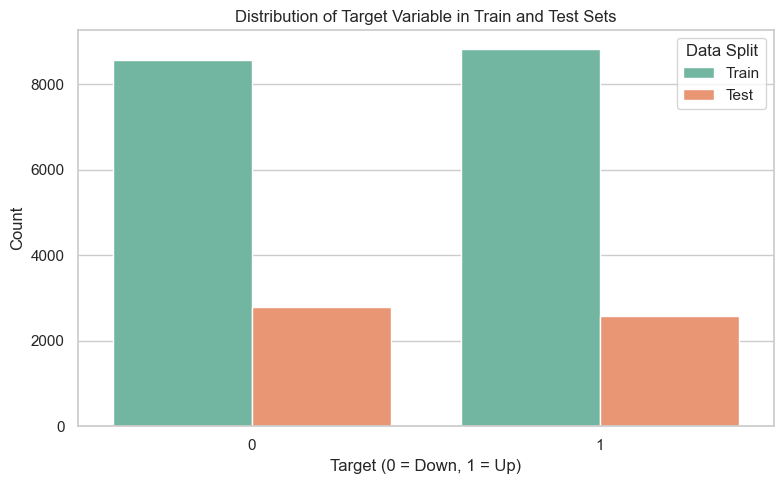

Target Distribution in Training Set:
target
1    8820
0    8561
Name: count, dtype: int64

Target Distribution in Test Set:
target
0    2782
1    2587
Name: count, dtype: int64

Target Percentage in Training Set:
target
1    50.7
0    49.3
Name: proportion, dtype: float64

Target Percentage in Test Set:
target
0    51.8
1    48.2
Name: proportion, dtype: float64


In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine train/test into one DataFrame
plot_df = pd.concat([
    pd.DataFrame({"target": y_train, "set": "Train"}),
    pd.DataFrame({"target": y_test, "set": "Test"})
])

# Plot
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=plot_df, x="target", hue="set", palette="Set2")

# Add count labels on top of bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

# Title and labels
plt.title("Distribution of Target Variable in Train and Test Sets")
plt.xlabel("Target (0 = Down, 1 = Up)")
plt.ylabel("Count")
plt.legend(title="Data Split")
plt.tight_layout()
plt.show()

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
# Get raw matrix
cm = confusion_matrix(y_test, y_pred)

# Print with labels
print("Confusion Matrix:")
print(f"                 Predicted 0   Predicted 1")
print(f"Actual 0     {cm[0][0]}             {cm[0][1]}")
print(f"Actual 1    {cm[1][0]}             {cm[1][1]}")

Accuracy: 0.49
              precision    recall  f1-score   support

           0       0.52      0.24      0.33      2782
           1       0.48      0.77      0.59      2587

    accuracy                           0.49      5369
   macro avg       0.50      0.50      0.46      5369
weighted avg       0.50      0.49      0.46      5369

Confusion Matrix:
                 Predicted 0   Predicted 1
Actual 0     662             2120
Actual 1    600             1987


/Users/frederikboysen/Desktop/10. semester Speciale/speciale/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


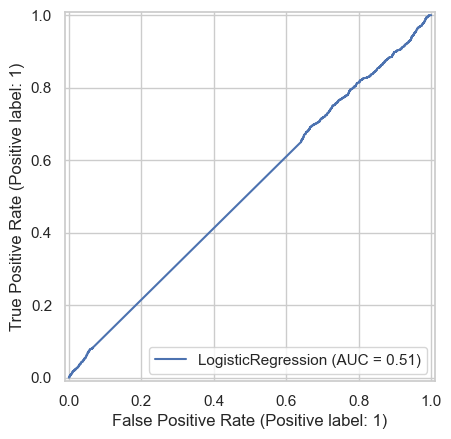

In [89]:
from sklearn.metrics import roc_curve, RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_test, y_test)


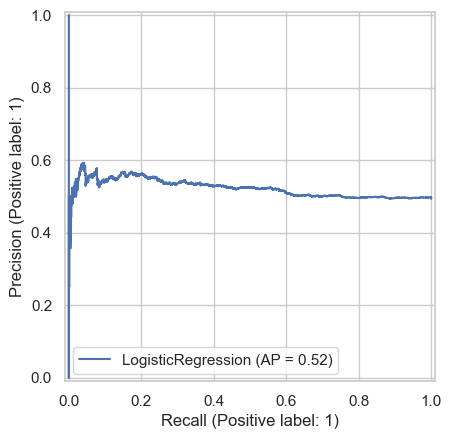

In [48]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(model, X_test, y_test)


Text(0.5, 1.0, 'Logistic Regression Coefficients')

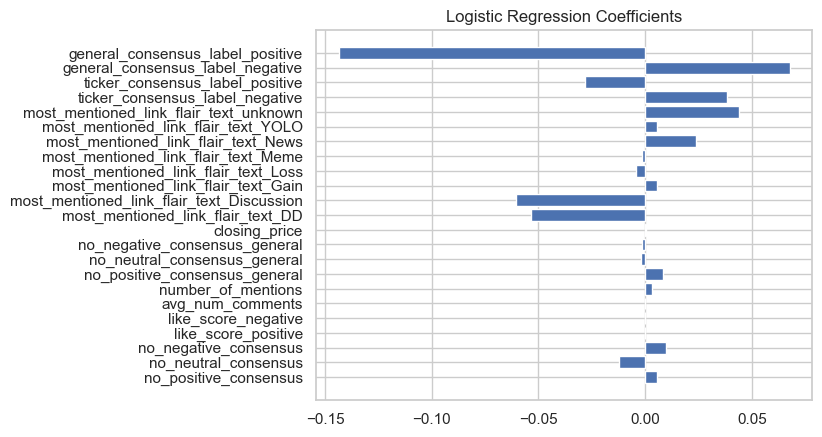

In [108]:
import matplotlib.pyplot as plt
coef = model.coef_[0]
features = X_train.columns
plt.barh(features, coef)
plt.title("Logistic Regression Coefficients")


In [107]:
# Predict probabilities
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Combine predictions with test features
results_df = X_test.copy()
results_df["Predicted_Label"] = y_pred
results_df["Actual_Label"] = y_test.values

# Filter to only include rows where number_of_mentions > 20
filtered_df = results_df[results_df["number_of_mentions"] > 20]

# Get metadata WITHOUT duplicating columns that already exist
metadata = df_stock_sentiment.loc[filtered_df.index, ["date", "ticker"]]

# Add metadata to filtered_df
final_df = pd.concat([filtered_df, metadata], axis=1)

# Now select the desired columns (only once!)
final_output = final_df[[
    "date",
    "ticker",
    "no_positive_consensus",
    "no_negative_consensus",
    "like_score_positive",
    "like_score_negative",
    "Predicted_Label",
    "Actual_Label"
]]

# Show a few rows
print(final_output.sample(10))


             date ticker  no_positive_consensus  no_negative_consensus  \
21737  2025-03-12   TSLA                    4.0                   13.0   
16211  2025-02-03   NVDA                    3.0                    9.0   
21711  2025-02-03   TSLA                    5.0                    7.0   
16207  2025-01-28   NVDA                   31.0                   22.0   
21741  2025-03-18   TSLA                   12.0                   11.0   
21736  2025-03-11   TSLA                    8.0                    9.0   
6952   2025-01-21    DJT                    6.0                    4.0   
16208  2025-01-29   NVDA                   16.0                   20.0   
20472  2025-02-19   SMCI                    6.0                    9.0   
15703  2025-01-22   NFLX                   14.0                    5.0   

       like_score_positive  like_score_negative  Predicted_Label  Actual_Label  
21737                 19.0               4657.0                1             0  
16211                  

In [109]:
# For the interpretation of the confusion matrix
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Define features
numeric_features = [
    "no_positive_consensus",
    "no_neutral_consensus",
    "no_negative_consensus",
    "like_score_positive",
    "like_score_negative",
    "avg_num_comments",
    "number_of_mentions",
    "no_positive_consensus_general",
    "no_neutral_consensus_general",
    "no_negative_consensus_general",
    "closing_price"
]

categorical_features = [
    "most_mentioned_link_flair_text",
    "ticker_consensus_label",
    "general_consensus_label"
]

# Drop rows with missing values
required_columns = numeric_features + categorical_features + ["target"]
final = df_stock_sentiment.dropna(subset=required_columns)

# One-hot encode categorical variables
final_encoded = pd.get_dummies(df_stock_sentiment[categorical_features], drop_first=True)

# Combine numeric + encoded categorical features
X = pd.concat([df_stock_sentiment[numeric_features], final_encoded], axis=1)
y = df_stock_sentiment["target"]

# 1. Ensure X and y are numeric
X = X.apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(y, errors="coerce")

# 2. Check if any columns in X are still object dtype (just in case)
print("❗ Non-numeric columns in X:", X.dtypes[X.dtypes == "object"])
print("✅ X shape BEFORE dropna:", X.shape)

# 3. Drop any rows with NaNs in X or y
valid = ~X.isnull().any(axis=1) & ~y.isnull()
X = X[valid]
y = y[valid]

print("✅ X shape AFTER dropna:", X.shape)
print("✅ y unique values:", y.unique())

# 4. Check target is binary (0 and 1)
assert set(y.unique()).issubset({0, 1}), "❌ Target y must be binary 0/1 only"

# 5. Fit model
# Explicit conversion to float64 arrays (guaranteed fix)
X_np = X.astype(np.float64)
y_np = np.asarray(y).astype(np.float64)

logit_model = sm.Logit(y, X_np).fit()
print(logit_model.summary())


❗ Non-numeric columns in X: Series([], dtype: object)
✅ X shape BEFORE dropna: (22750, 22)
✅ X shape AFTER dropna: (22750, 22)
✅ y unique values: [0 1]
         Current function value: 0.692349
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                22750
Model:                          Logit   Df Residuals:                    22729
Method:                           MLE   Df Model:                           20
Date:                Wed, 21 May 2025   Pseudo R-squ.:                0.001146
Time:                        14:35:51   Log-Likelihood:                -15751.
converged:                      False   LL-Null:                       -15769.
Covariance Type:            nonrobust   LLR p-value:                   0.01481
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

/Users/frederikboysen/Desktop/10. semester Speciale/speciale/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# --- Step 1: Set up pipeline ---
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# --- Step 2: Define hyperparameter grid ---
param_grid = {
    'knn__n_neighbors': list(range(2, 26))  # k from 2 to 25
}

# --- Step 3: Set up GridSearch with cross-validation ---
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,                      # 5-fold cross-validation
    scoring='accuracy',        # or use 'f1_macro' for multi-class balance
    n_jobs=-1                  # use all processors
)

# --- Step 4: Fit the grid search ---
grid_search.fit(X_train, y_train)

# --- Step 5: Show results ---
print("🔍 Best k:", grid_search.best_params_['knn__n_neighbors'])
print("✅ Best CV accuracy:", round(grid_search.best_score_, 3))

# Optional: use best model to predict test set
best_knn_model = grid_search.best_estimator_
y_pred = best_knn_model.predict(X_test)

# After fitting GridSearchCV
results = grid_search.cv_results_

print("🔢 K values and their CV accuracy scores:")
for mean_score, k in zip(results["mean_test_score"], results["param_knn__n_neighbors"]):
    print(f"k = {k}: accuracy = {round(mean_score, 3)}")


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Step 1: Use the best model from grid search ---
best_knn_model = grid_search.best_estimator_

# --- Step 2: Predict on the test set ---
y_pred_knn = best_knn_model.predict(X_test)

# --- Step 3: Evaluate performance ---
print("🔹 KNN Accuracy (k=15):", round(accuracy_score(y_test, y_pred_knn), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

# --- Step 4: Confusion matrix for 2 classes ---
cm = confusion_matrix(y_test, y_pred_knn)
print("\nConfusion Matrix:")
print(f"                 Predicted 0   Predicted 1")
print(f"Actual 0     {cm[0][0]}             {cm[0][1]}")
print(f"Actual 1     {cm[1][0]}             {cm[1][1]}")


Random Forest

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Parameters
n_features = X_train.shape[1]
tree_counts = list(range(10, 510, 10))  # Number of trees from 10 to 500
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define different mtry (max_features) values
m_values = {
    "m=1": 1,
    "m=p/4": int(n_features / 4),
    "m=√p": int(np.sqrt(n_features)),
    "m=p/2": int(n_features / 2),
    "m=p": n_features
}

# Store training errors and best parameters
train_errors = {label: [] for label in m_values}
best_params = {"label": None, "n_estimators": None, "train_error": float("inf")}

# Grid search
for label, mtry in m_values.items():
    for n_trees in tree_counts:
        rf = RandomForestClassifier(
            n_estimators=n_trees,
            max_features=mtry,
            random_state=42,
            n_jobs=-1
        )
        # Cross-validated training accuracy
        scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='accuracy')
        train_error = 1 - scores.mean()
        train_errors[label].append(train_error)

        # Update best parameters
        if train_error < best_params["train_error"]:
            best_params["label"] = label
            best_params["n_estimators"] = n_trees
            best_params["train_error"] = train_error


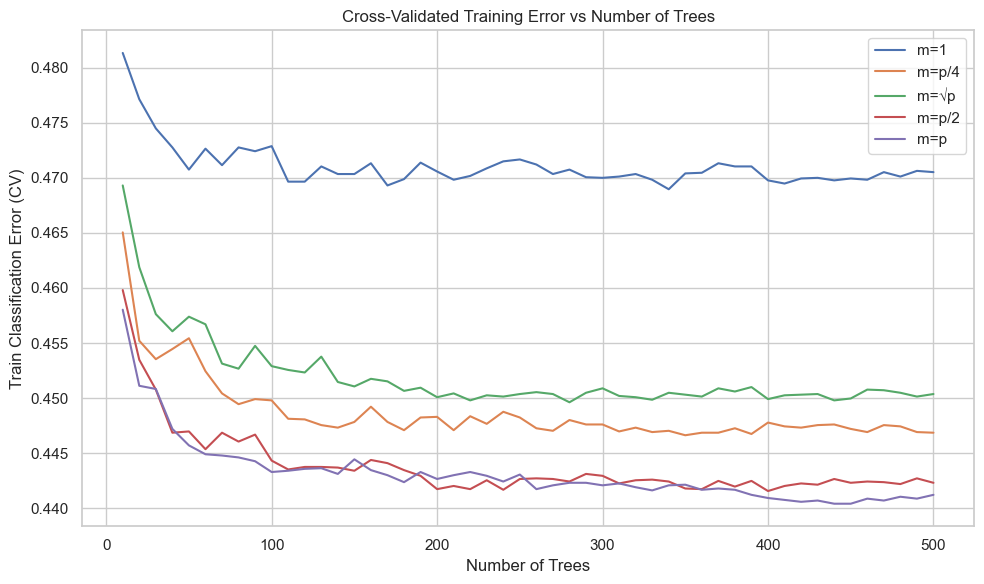

In [111]:
plt.figure(figsize=(10, 6))

for label, errors in train_errors.items():
    plt.plot(tree_counts, errors, label=label)

plt.xlabel("Number of Trees")
plt.ylabel("Train Classification Error (CV)")
plt.title("Cross-Validated Training Error vs Number of Trees")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [112]:
# Optimal parameters
print("Optimal parameters:")
print(f"  max_features: {best_params['label']}")
print(f"  n_estimators: {best_params['n_estimators']}")
print(f"  training error (CV): {best_params['train_error']:.4f}")


Optimal parameters:
  max_features: m=p
  n_estimators: 450
  training error (CV): 0.4404


In [113]:
# Train the final model with optimal parameters

from sklearn.ensemble import RandomForestClassifier

# Set optimal max_features (m = p/2)
optimal_m = int(n_features / 2)

# Create model with optimal parameters
rf_model = RandomForestClassifier(
    n_estimators=480,          # Optimal number of trees
    max_features=optimal_m,    # Optimal number of features per split
    max_depth=None,            # Let trees grow fully
    random_state=123
)

# Fit model
rf_model.fit(X_train, y_train)


RandomForestClassifier(max_features=11, n_estimators=480, random_state=123)

In [80]:
import pandas as pd

# Assuming your features are in a DataFrame called X_train
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)
print(importances)


avg_num_comments                             0.199595
like_score_positive                          0.121755
no_neutral_consensus_general                 0.101991
no_negative_consensus_general                0.099944
no_positive_consensus_general                0.085960
number_of_mentions                           0.061716
like_score_negative                          0.060708
no_neutral_consensus                         0.052644
no_positive_consensus                        0.046399
no_negative_consensus                        0.028233
most_mentioned_link_flair_text_Discussion    0.025657
most_mentioned_link_flair_text_DD            0.022609
ticker_consensus_label_positive              0.015154
most_mentioned_link_flair_text_Gain          0.012587
most_mentioned_link_flair_text_News          0.011561
ticker_consensus_label_negative              0.011217
most_mentioned_link_flair_text_YOLO          0.010854
most_mentioned_link_flair_text_Meme          0.006902
most_mentioned_link_flair_te

In [114]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(f"                 Predicted 0   Predicted 1")
print(f"Actual 0     {cm[0][0]}             {cm[0][1]}")
print(f"Actual 1     {cm[1][0]}             {cm[1][1]}")


Accuracy: 0.5105233749301545

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.48      0.50      2782
           1       0.49      0.54      0.52      2587

    accuracy                           0.51      5369
   macro avg       0.51      0.51      0.51      5369
weighted avg       0.51      0.51      0.51      5369


Confusion Matrix:
                 Predicted 0   Predicted 1
Actual 0     1336             1446
Actual 1     1182             1405


/var/folders/zn/s6zzv27j6jxfgw75rmyw03_r0000gn/T/ipykernel_89719/1839723201.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values[:top_n], y=importances.index[:top_n], palette="viridis")


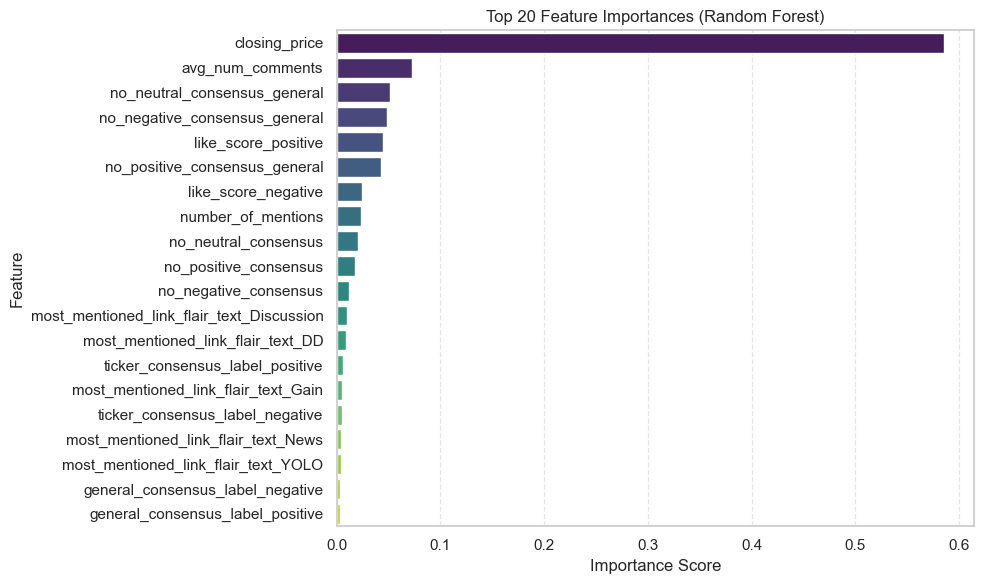

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances from the trained model
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

# Plot top N features (e.g., top 20)
top_n = 20
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:top_n], y=importances.index[:top_n], palette="viridis")

plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()


In [118]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 200, 300, 400, 500],
    'max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best model and evaluation
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", round(grid_search.best_score_, 3))

# Predict on test set
y_pred = grid_search.best_estimator_.predict(X_test)


Best parameters: {'max_depth': 10, 'n_estimators': 300}
Best CV accuracy: 0.559


In [119]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(f"                 Predicted 0   Predicted 1")
print(f"Actual 0     {cm[0][0]}             {cm[0][1]}")
print(f"Actual 1     {cm[1][0]}             {cm[1][1]}")


Test Accuracy: 0.5041907245297076
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.23      0.33      2782
           1       0.49      0.80      0.61      2587

    accuracy                           0.50      5369
   macro avg       0.52      0.51      0.47      5369
weighted avg       0.52      0.50      0.46      5369


Confusion Matrix:
                 Predicted 0   Predicted 1
Actual 0     648             2134
Actual 1     528             2059


XGBOOST

In [120]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Step 1: Set up model (no need for scaling in XGBoost) ---
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',  # suppresses warning
    random_state=42
)

# --- Step 2: Define hyperparameter grid ---
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500, 1000, 2000, 3000],         
    'max_depth': [2, 3, 4, 5, 7, 10],                    
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]      
}

# --- Step 3: Set up cross-validated grid search ---
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    n_jobs=-1
)

# --- Step 4: Fit on training data ---
grid_search.fit(X_train, y_train)

# --- Step 5: Use best model for predictions ---
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# --- Step 6: Evaluate performance ---
print("Best parameters:", grid_search.best_params_)
print("Best CV Accuracy:", round(grid_search.best_score_, 3))
print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Step 7: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix:")
print(f"                 Predicted 0   Predicted 1")
print(f"Actual 0     {cm[0][0]}             {cm[0][1]}")
print(f"Actual 1     {cm[1][0]}             {cm[1][1]}")


/Users/frederikboysen/Desktop/10. semester Speciale/speciale/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/frederikboysen/Desktop/10. semester Speciale/speciale/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/frederikboysen/Desktop/10. semester Speciale/speciale/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:55:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/frederikboysen/Desktop/10. semester Speciale/speciale/.venv/lib/python3.11/sit

Best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
Best CV Accuracy: 0.565
Test Accuracy: 0.508

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.29      0.38      2782
           1       0.49      0.74      0.59      2587

    accuracy                           0.51      5369
   macro avg       0.52      0.52      0.49      5369
weighted avg       0.52      0.51      0.48      5369


 Confusion Matrix:
                 Predicted 0   Predicted 1
Actual 0     812             1970
Actual 1     674             1913


/var/folders/zn/s6zzv27j6jxfgw75rmyw03_r0000gn/T/ipykernel_89719/368830024.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')


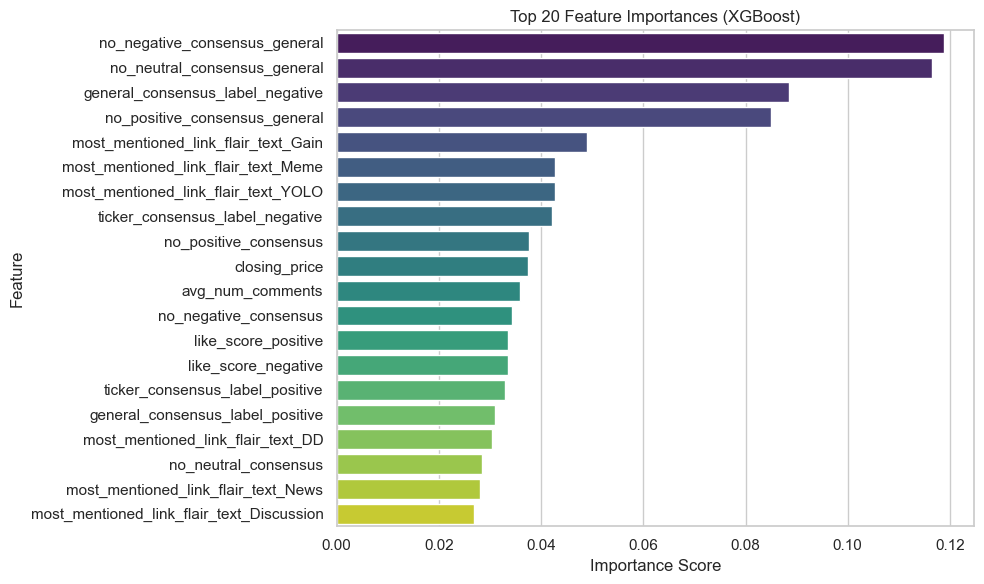


Full Feature Importances (sorted):
                                  Feature  Importance
            no_negative_consensus_general    0.118769
             no_neutral_consensus_general    0.116511
         general_consensus_label_negative    0.088475
            no_positive_consensus_general    0.084985
      most_mentioned_link_flair_text_Gain    0.048897
      most_mentioned_link_flair_text_Meme    0.042819
      most_mentioned_link_flair_text_YOLO    0.042734
          ticker_consensus_label_negative    0.042180
                    no_positive_consensus    0.037610
                            closing_price    0.037538
                         avg_num_comments    0.035877
                    no_negative_consensus    0.034277
                      like_score_positive    0.033516
                      like_score_negative    0.033463
          ticker_consensus_label_positive    0.033002
         general_consensus_label_positive    0.030911
        most_mentioned_link_flair_text_DD    0

In [121]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# --- Step 8: Feature Importance ---
# Get feature importances from the best XGBoost model
importances = best_xgb.feature_importances_
feature_names = X_train.columns

# Create DataFrame for easier plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Top 20 Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Optional: Print full sorted list
print("\nFull Feature Importances (sorted):")
print(importance_df.to_string(index=False))
